# Classical Music Kaggle Competition

Author: Zach Xing

In [1]:
import pandas as pd
import numpy as np
import re



### Description
We have received several data files as described below to use in our model. Our training dataset in train.csv contains account IDs of patrons along with a target label (0 or 1) indicating whether they purchased a subscription for the 2014-15 concert season. Our objective is to predict whether the patrons listed in the test.csv file will purchase subscriptions or not. Be sure that your output file matches exactly with the format in the sample_submissions.csv file, including the same column headings. You should submit your "soft predictions" (your probabilistic prediction that they will purchase a subscription), NOT discrete 0/1 predictions, since our scoring metric for this competition is AUROC.



### Data

train.csv - the training set containing target labels indicating whether the patrons have purchased a 2014-15 subscription or not

test.csv - the test set of accounts for which we are to make a prediction

sample_submission.csv - a sample submission file in the correct format

account.csv - location info for each patron and donation history

tickets_all.csv - previously purchased tickets by account

subscriptions.csv - previously purchased subscriptions by account

concerts.csv - previous concerts by season.

concerts_2014-15.csv - list of planned concert sets for the 2014-15 season

zipcodes.csv - location and demographic information for zipcodes

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_account = pd.read_csv('account.csv', encoding='latin-1')
df_tickets = pd.read_csv('tickets_all.csv')
df_sub = pd.read_csv('subscriptions.csv')
df_concerts = pd.read_csv('concerts.csv')
df_concerts1415 = pd.read_csv('concerts_2014-15.csv')
df_zipcodes = pd.read_csv('zipcodes.csv')

In [3]:
# replace \r with , in who column
df_concerts['who'] = df_concerts['who'].str.replace('\r', ',')

In [4]:
def extract_names(s):
    # Regular expression pattern to match two consecutive capitalized words
    pattern = r'\b([A-Z][a-zA-Z]+(?:\s[A-Z][a-zA-Z]+)+)\b'
    return re.findall(pattern, s)

In [5]:
df_concerts1415['extracted_names'] = df_concerts1415['who'].apply(extract_names)
df_concerts['extracted_names'] = df_concerts['who'].apply(extract_names)

names_list_1415 = np.unique([name for sublist in df_concerts1415['extracted_names'].tolist() for name in sublist]).tolist()
names_list_1415

['Adler Fellowship Program Ted Huffman',
 'Andreas Scholl',
 'Brian Thorsett',
 'Bruce Lamott',
 'Christopher Ainslie',
 'Clifton Massey',
 'Dashon Burton',
 'Dominique Labelle',
 'Jeffrey Fields',
 'Julian Wachner',
 'Nicholas McGegan',
 'Rachel Podger',
 'San Francisco Opera',
 'Sherezade Panthaki',
 'Steven Isserlis',
 'The Philharmonia Chorale',
 'Thomas Cooley']

In [6]:
# get all the season of each unique account.id
grouped_season_eachID = df_sub.groupby('account.id')['season'].unique().reset_index()


In [7]:
# Extract all the performers of the past seasons
df_concerts_extract_names = df_concerts.groupby('season')['extracted_names'].sum().reset_index()
df_concerts_extract_names['unique_names'] = df_concerts_extract_names['extracted_names'].apply(lambda x: list(set(x)))
df_concerts_extract_names.drop('extracted_names', axis=1, inplace=True)

In [8]:
# As we only have the data of the past 4 seasons, we will only consider past 4 seasons here
df_sub_10_14 = df_sub[df_sub['season'].isin(['2010-2011', '2011-2012', '2012-2013', '2013-2014'])]
df_sub_10_14 = pd.merge(df_sub_10_14, df_concerts_extract_names, on='season', how='left')

In [9]:
df_sub_10_14

,account.id,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs,unique_names
0,001i000000LhycQ,2012-2013,Trio A,2,Peninsula,Orchestra,4.0,1.0,no,"[Bruce Lamott, Brian Thorsett, Helene Zindarsi..."
1,001i000000LhyaV,2012-2013,Trio B,1,Peninsula,Orchestra,1.0,0.5,no,"[Bruce Lamott, Brian Thorsett, Helene Zindarsi..."
2,001i000000NuQvL,2010-2011,Full,1,Berkeley Saturday,Balcony Front,3.0,1.0,no,"[Bruce Lamott, Dominique Labelle, Philip Cutli..."
3,001i000000LhyXZ,2013-2014,Trio A,1,Peninsula,NaN,1.0,0.5,no,"[Tanya Tomkins, Virginia Warnken, Bruce Lamott..."
4,001i000000LhyRY,2010-2011,Full,2,San Francisco,Orchestra,1.0,2.0,no,"[Bruce Lamott, Dominique Labelle, Philip Cutli..."
...,...,...,...,...,...,...,...,...,...,...
4124,001i000000NuNxH,2013-2014,Trio A,1,San Francisco,NaN,1.0,0.5,no,"[Tanya Tomkins, Virginia Warnken, Bruce Lamott..."
4125,001i000000NuQ6f,2010-2011,Quartet CC,2,Contra Costa,Orchestra,2.0,1.0,no,"[Bruce Lamott, Dominique Labelle, Philip Cutli..."
4126,001i000000LhyPW,2012-2013,Full,2,Berkeley Sunday,Orchestra,0.0,2.0,no,"[Bruce Lamott, Brian Thorsett, Helene Zindarsi..."
4127,001i000000LhyaC,2012-2013,Trio A,1,Berkeley Saturday,Balcony Front,3.0,0.5,no,"[Bruce Lamott, Brian Thorsett, Helene Zindarsi..."


In [10]:
agg_names = df_sub_10_14.groupby('account.id').apply(
    lambda group: list(set(name for sublist in group['unique_names'] for name in sublist))
).reset_index()

agg_names.columns = ['account.id', 'aggregated_unique_names']

agg_names

,account.id,aggregated_unique_names
0,001i000000LhyPD,"[Philip Cutlip, Bruce Lamott, Brian Thorsett, ..."
1,001i000000LhyPE,"[Philip Cutlip, Bruce Lamott, Brian Thorsett, ..."
2,001i000000LhyPF,"[Philip Cutlip, Bruce Lamott, Brian Thorsett, ..."
3,001i000000LhyPG,"[Philip Cutlip, Bruce Lamott, Brian Thorsett, ..."
4,001i000000LhyPH,"[Philip Cutlip, Bruce Lamott, Brian Thorsett, ..."
...,...,...
1523,001i000000V23aW,"[David Daniels, Tanya Tomkins, Virginia Warnke..."
1524,001i000000V24lZ,"[David Daniels, Tanya Tomkins, Virginia Warnke..."
1525,001i000000V24u1,"[David Daniels, Tanya Tomkins, Virginia Warnke..."
1526,001i000000V255R,"[David Daniels, Tanya Tomkins, Virginia Warnke..."


In [11]:
agg_names['count_in_list'] = agg_names['aggregated_unique_names'].apply(
    lambda names: sum([1 for name in names if name in names_list_1415])
)

agg_names_count = agg_names[['account.id', 'count_in_list']]

In [12]:
# Transfer 4.0 to 4 in price.level column
df_tickets['price.level'] = df_tickets['price.level'].apply(lambda x: str(x).split('.')[0])


In [13]:
df_tickets_count = df_tickets.groupby(['account.id']).size().reset_index(name='tickets_counts')

In [14]:
# Sort the dataframe by season and extract unique account.id
df_tickets['season'] = df_tickets['season'].apply(lambda x: str(x).split('-')[0])
df_tickets_unique = df_tickets.sort_values('season').drop_duplicates(['account.id'], keep='last')


In [15]:
# Identify top 5 most frequent values
N = 5
no_seats_top_values = df_tickets_unique['no.seats'].value_counts().head(N).index.tolist()
df_tickets_unique['processed_no_seats'] = df_tickets_unique['no.seats'].apply(lambda x: x if x in no_seats_top_values else 'Other')

In [16]:
df_tickets_encode = pd.get_dummies(df_tickets_unique, columns=['price.level','processed_no_seats','multiple.tickets'], prefix=['dummy_priceLevel','dummy_seats','dummy_multiple'])
# drop the columns number in range of 1:6
df_tickets_encode.drop(df_tickets_encode.columns[1:6], inplace=True, axis=1)

In [17]:
df_concerts1415

,season,concert.name,set,who,what,extracted_names
0,2014-2015,"Steven Isserlis, Boccherini, and Haydn",1,"Nicholas McGegan, conductor, Steven Isserlis, ...",BOCCHERINIConcerto for Violoncello No. 7 in G ...,"[Nicholas McGegan, Steven Isserlis]"
1,2014-2015,"Andreas Scholl, J.S. Bach, and Handel",2,"Julian Wachner, conductor, Andreas Scholl, cou...",HANDELArias including ÒVa tacitoÓ from Giulio ...,"[Julian Wachner, Andreas Scholl]"
2,2014-2015,Vivaldi and Zelenka: A Joyous Christmas,3,"Nicholas McGegan, conductor, Dominique Labelle...","VIVALDI Dixit Dominus, RV 807 ZELENKA Missa Na...","[Nicholas McGegan, Dominique Labelle, Christop..."
3,2014-2015,The Cousins Bach,4,"Nicholas McGegan, conductor Sherezade Panthaki...","Johann Ludwig BACH, Trauermusik, Johann Christ...","[Nicholas McGegan, Sherezade Panthaki, Clifton..."
4,2014-2015,Rachel Podger and Vivaldi,5,"Rachel Podger, violin and leader",VIVALDI Violin concertos from LÕestro armonico...,[Rachel Podger]
5,2014-2015,RossiniÕs The Marriage Contract,6,"Nicholas McGegan, conductor Soloists from San ...",ROSSINI La cambiale di matrimonio (The Marriag...,"[Nicholas McGegan, San Francisco Opera, Adler ..."


In [18]:
df_account

,account.id,shipping.zip.code,billing.zip.code,shipping.city,billing.city,relationship,amount.donated.2013,amount.donated.lifetime,no.donations.lifetime,first.donated
0,001i000000LhSrQ,94102,94102,San Francisco,San Francisco,NaN,0.0,0.0,0,NaN
1,001i000000LhyPD,NaN,94303,NaN,Palo Alto,NaN,0.0,500.0,5,1987-07-04 00:00:00
2,001i000000LhyPE,NaN,94597,NaN,Walnut Creek,NaN,0.0,783.0,7,2008-06-02 00:00:00
3,001i000000LhyPF,NaN,94610,NaN,Oakland,NaN,1500.0,28435.0,28,1986-07-04 00:00:00
4,001i000000LhyPG,NaN,94024,NaN,Los Altos,NaN,300.0,4969.0,16,1997-04-07 00:00:00
...,...,...,...,...,...,...,...,...,...,...
19828,001i0000018BZTP,NaN,95014,NaN,Cupertino,NaN,0.0,0.0,0,NaN
19829,001i0000018BZTt,NaN,94521,NaN,Concord,NaN,0.0,0.0,0,NaN
19830,001i0000018BZUN,NaN,94552,NaN,castro valley,NaN,0.0,0.0,0,NaN
19831,001i0000018BZUr,NaN,94043,NaN,Mountain view,NaN,0.0,0.0,0,NaN


In [19]:
# Identify top N most frequent values
N = 5
shipping_cities_top_values = df_account['shipping.city'].value_counts().head(N).index.tolist()
relationship_top_values = df_account['relationship'].value_counts().head(N).index.tolist()

# Convert values that are not in the top N to 'Other'
df_account['processed_shipping_cities'] = df_account['shipping.city'].apply(lambda x: x if x in shipping_cities_top_values else 'Other')
df_account['processed_relationship'] = df_account['relationship'].apply(lambda x: x if x in relationship_top_values else 'Other')

# One-hot encode the processed column
df_encoded = pd.get_dummies(df_account, columns=['processed_shipping_cities', 'processed_relationship'],prefix=['dummy_shipping_city', 'dummy_relationship'])

In [20]:
# Get the number of subscriptions per account
df_sub_counts = df_sub.groupby('account.id').count()

In [21]:
df_all = df_encoded.merge(df_sub_counts, on='account.id', how='left')
encoded_columns = df_encoded.filter(like='dummy_', axis=1).columns.tolist()
df_target = df_all[['account.id', 'amount.donated.2013', 'amount.donated.lifetime', 'season']+encoded_columns].fillna(0)
df_target = df_target.merge(df_tickets_count, on='account.id', how='left').fillna(0)
df_target = df_target.merge(agg_names_count, on='account.id', how='left').fillna(0)
# df_target = df_target.merge(df_tickets_encode, on='account.id', how='left').fillna(False)


In [22]:
df_train_1 = df_train.merge(df_target, on='account.id', how='left')

In [23]:
df_train_1

,account.id,label,amount.donated.2013,amount.donated.lifetime,season,dummy_shipping_city_Berkeley,dummy_shipping_city_Oakland,dummy_shipping_city_Other,dummy_shipping_city_Palo Alto,dummy_shipping_city_San Francisco,dummy_shipping_city_Walnut Creek,dummy_relationship_Education Participant,dummy_relationship_Other,dummy_relationship_Peer Organization,dummy_relationship_Vendor - Artistic,dummy_relationship_Vendor - General,dummy_relationship_Vendor - Marketing,tickets_counts,count_in_list
0,001i000000NuRo3,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
1,001i000000NuRxd,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
2,001i000000NuQGN,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
3,001i000000NuPfL,0,0.0,0.0,1.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
4,001i000000NuQkP,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,001i000000NuOqz,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6937,001i000000NuQXQ,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6938,001i000000NuSoR,0,0.0,18000.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6939,001i000000NuO7r,0,0.0,246.0,8.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0


In [24]:
df_train_1.drop(['account.id'], inplace=True, axis=1)

In [25]:
X = df_train_1.loc[:, df_train_1.columns != 'label']
y = df_train_1['label']

In [26]:
# split the train data into train and validation
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=18)

In [27]:
# develop a xgboost model, using only the training data. Use auroc as the metric
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# create a linear regression model
logreg = linear_model.LogisticRegression(C=1e5)
# train the model
logreg.fit(X_train, y_train)
# predict on the validation data, use "soft predictions" (your probabilistic prediction)
y_pred = logreg.predict_proba(X_val)[:, 1]

# calculate the auroc
roc_auc_score(y_val, y_pred)


/Users/Zach/anaconda3/envs/AIPI520/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9084494321132612

In [28]:
import xgboost as xgb
from sklearn.metrics import roc_auc_score

# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

# Train the XGBoost model
bst = xgb.train(param, dtrain)

# Predict on the validation data
dval = xgb.DMatrix(X_val)
y_pred = bst.predict(dval)

# Calculate the AUROC
auroc = roc_auc_score(y_val, y_pred)
print(f"AUROC: {auroc:.4f}")

AUROC: 0.9610


### Neural Network

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [30]:
def prep_dataloaders(X_train,y_train,X_test,y_test,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train).astype('float32')), 
                            torch.from_numpy(np.array(y_train).astype('float32')).view(-1,1))
    testset = TensorDataset(torch.from_numpy(np.array(X_test).astype('float32')), 
                            torch.from_numpy(np.array(y_test).astype('float32')).view(-1,1))

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

batchsize = 32
trainloader,testloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [31]:
class RegressionNet(nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super().__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

# Instantiate our neural network
net = RegressionNet(n_hidden1=50, n_hidden2=5)

In [32]:
# Define our loss function for classification, Binary Cross Entropy
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [33]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    cost = []
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

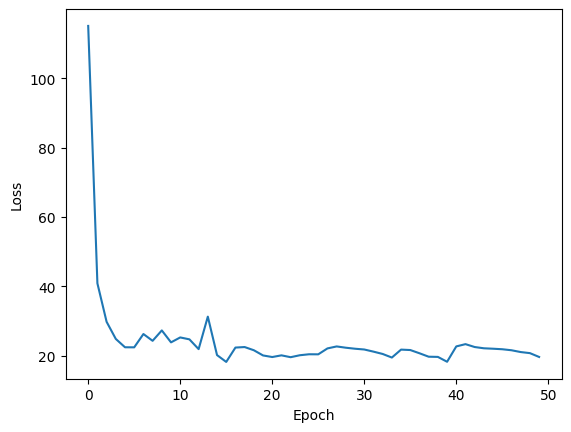

In [34]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of iterations (epochs) to train
n_iter = 50

cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [35]:
def test_model(model,test_loader):
    # Turn autograd off
    with torch.no_grad(): 
        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()
        test_preds = []
        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model.forward(inputs)
            test_preds.extend(outputs.cpu().squeeze().tolist())

    return test_preds

testpreds = test_model(net,testloader)
test_auroc = roc_auc_score(y_val, testpreds)
print(f"AUROC: {test_auroc:.4f}")

AUROC: 0.9272


### Predictions

In [36]:
# reset the column 'ID' to 'account.id'
df_test = df_test.rename(columns={'ID': 'account.id'})
# predict on the test data

df_test_1 = df_test.merge(df_target, on='account.id', how='left')
X_test = df_test_1.loc[:, df_test_1.columns != 'account.id']

dval_test = xgb.DMatrix(X_test)
df_test_1['label'] = bst.predict(dval_test)

# df_test_1['label'] = logreg.predict_proba(df_test_1)[:, 1]
df_test_1 = df_test_1[['account.id', 'label']]
df_test_1 = df_test_1.rename(columns={'account.id': 'ID', 'label': 'Predicted'})


In [37]:
df_test_1

,ID,Predicted
0,001i000000NuQ6Y,0.043528
1,001i000000NuQXz,0.179851
2,001i000000NuRDC,0.023678
3,001i000000NuQeg,0.014815
4,001i000000NuOQc,0.060994
...,...,...
2970,001i000000NuP3y,0.008563
2971,001i000000NuRib,0.008991
2972,001i000000NuP7J,0.008486
2973,001i000000NuRJd,0.019630


In [38]:
# df_test_1.to_csv('submission_test.csv', index=False)